# Model 2 - Simulation Process
The main difference between this model and the previous ones is that here we consider 2 traits: the cell size $m(t)$ and its protein content $p(t)$. We call $\underline{x}$ the vector
$$
\underline{x} = \begin{pmatrix} m\\ p\end{pmatrix} 
$$

As before, the traits evolution and the cell division are governed by $g(\underline{x})$ and $h(p)$ respectively, which are defined as 
$$
\begin{aligned}
g(\underline{x})&=\omega_1m \cdot \begin{pmatrix} 1\\ c\end{pmatrix} \\
h(p)&=
    \begin{cases}
    0   & , \, p<u \\
    \omega_2 \, \frac{p+v}{u+v} & , \, p\geq u
    \end{cases}
\end{aligned}
$$
From $g(\underline{x})$ we can notice that the cell size still grows exponentially and the protein content also follows this evolution, scaled by the factor $c$. As $c$ doesn't have a real meaning, we set it to $1$. 

Moreover, in this model the condition under which the cell can divide is that it contains a minimum amount of a specific type of protein, which we call $u$. If $p\geq u$ the cell can divide, otherwise it cannot. Unlike [model 1](model_1.ipynb), we do not have any conditions on the size of the cell for the division to take place and $h$ depens only on $p$.

The initial conditions for $m(t)$ and $p(t)$ are
$$
\begin{aligned}
    p(t=0) &= 0 \\
    m(t=0) &= m_b
\end{aligned}
$$

The division process in this model occurs in the following way
$$
\begin{pmatrix} m \\ p\end{pmatrix} \rightarrow \begin{pmatrix} \text{f}  m \\ 0\end{pmatrix} + \begin{pmatrix} (1-\text{f}) \cdot m \\ 0\end{pmatrix}
$$
where for now we keep $\text{f}=0.5$.

## Analytical solution of the differential equations
The results of the two differential equations are:
$$
\begin{aligned}

m(t) &= m_b\, e^{\omega_1 t} \\
p(t) &= m_b\, \left(e^{\omega_1 t}-1 \right) \\



\ln(s(t)) &= - \left[ \dfrac{m_b}{\mu+\nu} \dfrac{\omega_2}{\omega_1} \left( e^{\omega_1 t} - e^{\omega_1 t_0}\right) + \dfrac{\nu - m_b}{\mu+\nu}\, \omega_2 (t-t_0) \right] \theta   (t-t_0) \\




%s(t) &= \exp\left\{ - \left[ \dfrac{m_b}{\mu+\nu} \dfrac{\omega_2}{\omega_1} \left.         %(e^\omega_1 t} - e^{\omega_1 t_0}\right) + \dfrac{\nu - m_b}{\mu+\nu}\, \omega_2 (t-t_0) %\right] \theta(t-t_0) \right\}



\end{aligned}

$$

where $t_0 \equiv \dfrac{1}{\omega_1} \ln\left(1 + \dfrac{\mu}{m_b}\right) $ is the minimum time at which the cell can divide and $\theta(\tau)$ is the Heaviside function.



In [1]:
import math
import numpy as np
from scipy import stats
from pynverse import inversefunc
import pandas as pd
import emcee
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import seaborn as sns

import sys
sys.path.insert(0, '/work/Microbial_Scaling_Laws/analysis_real_data')
from Fernando_package.functions import prior_mu, prior_omega1, prior_omega2, prior_nu

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [2]:
np.random.seed(seed=123)

size = 100 # length of the time series (= number of divisions)
s_drawn = np.random.uniform(low=0, high = 1, size = size)
ln_s_drawn = np.log(s_drawn)
print('Some drawn values of s:', s_drawn[:5])

Some drawn values of s: [0.69646919 0.28613933 0.22685145 0.55131477 0.71946897]


In [3]:
'''
Cell size evolution m(t)
'''
def m_function(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, mb) = pars

    m_ = (mb)*np.exp(omega1*t)
    return m_


'''
Protein content evolution p(t)
'''
def p_function(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, mb) = pars

    
    p_ = (mb)*(np.exp(omega1*t) - 1)
    return p_


'''
Hazard rate function h(t)
'''
def h(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, mb) = pars

    h_ = omega2*((p_function(t, pars) + nu)/(mu+nu)) # if p(t) ≥ mu
    h_[p_function(t, pars) < mu] = 0                 # if p(t) < mu
    
    return h_


'''
Logarithm of survival function s(t) for a float t
'''
def log_CDF_float(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, mb) = pars

    # threshold time
    t0 = (1.0/omega1) * np.log(1 + (mu/mb))
    #t0 = max([0, (1.0/omega1) * np.log(1 + (mu/mb))])
    if t>=t0:
        ln_s_ = - ( (mb/(mu+nu)) * (omega2/omega1) * (np.exp(omega1*t)-np.exp(omega1*t0)) +\
                    ((nu-mb)/(mu+nu)) * omega2 * (t-t0) )
    else:
        ln_s_ = 0

    return ln_s_


'''
Logarithm of survival function s(t) for an array t
'''
# threshold time

def log_CDF_arr(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, mb) = pars

    t0 = (1.0/omega1) * np.log(1 + (mu/mb))
    

    ln_s_ = - ( (mb/(mu+nu)) * (omega2/omega1) * (np.exp(omega1*t)-np.exp(omega1*t0)) +((nu-mb)/(mu+nu)) * omega2 * (t-t0) )
    
    
    
    ln_s_[t < t0] = 0                 # if p(t) < mu

    return ln_s_


'''
Logarithm of survival function s(t)
'''
def log_CDF(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, mb) = pars

    if type(t) == np.ndarray: # array
        ln_s_ = log_CDF_arr(t, pars)
    else: # float
        ln_s_ = log_CDF_float(t, pars)

    return ln_s_


'''
Survival function s(t)
'''
def CDF(t, pars=(1,0.9,0.1,1,1)):
    return np.exp(log_CDF(t, pars))

In [4]:
'''
Find tau numerically
'''
def draw_tau_numerical(log_K, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, mb) = pars

    # threshold time
    t0 = max([0, (1.0/omega1) * np.log(1 + (mu/mb))])
    t_max = 100/omega1 # approx. 100 tau to avoid roundoff error

    tau = inversefunc(log_CDF, args=(pars,), y_values=log_K, domain=[0,t_max], open_domain=True)
    
    return tau

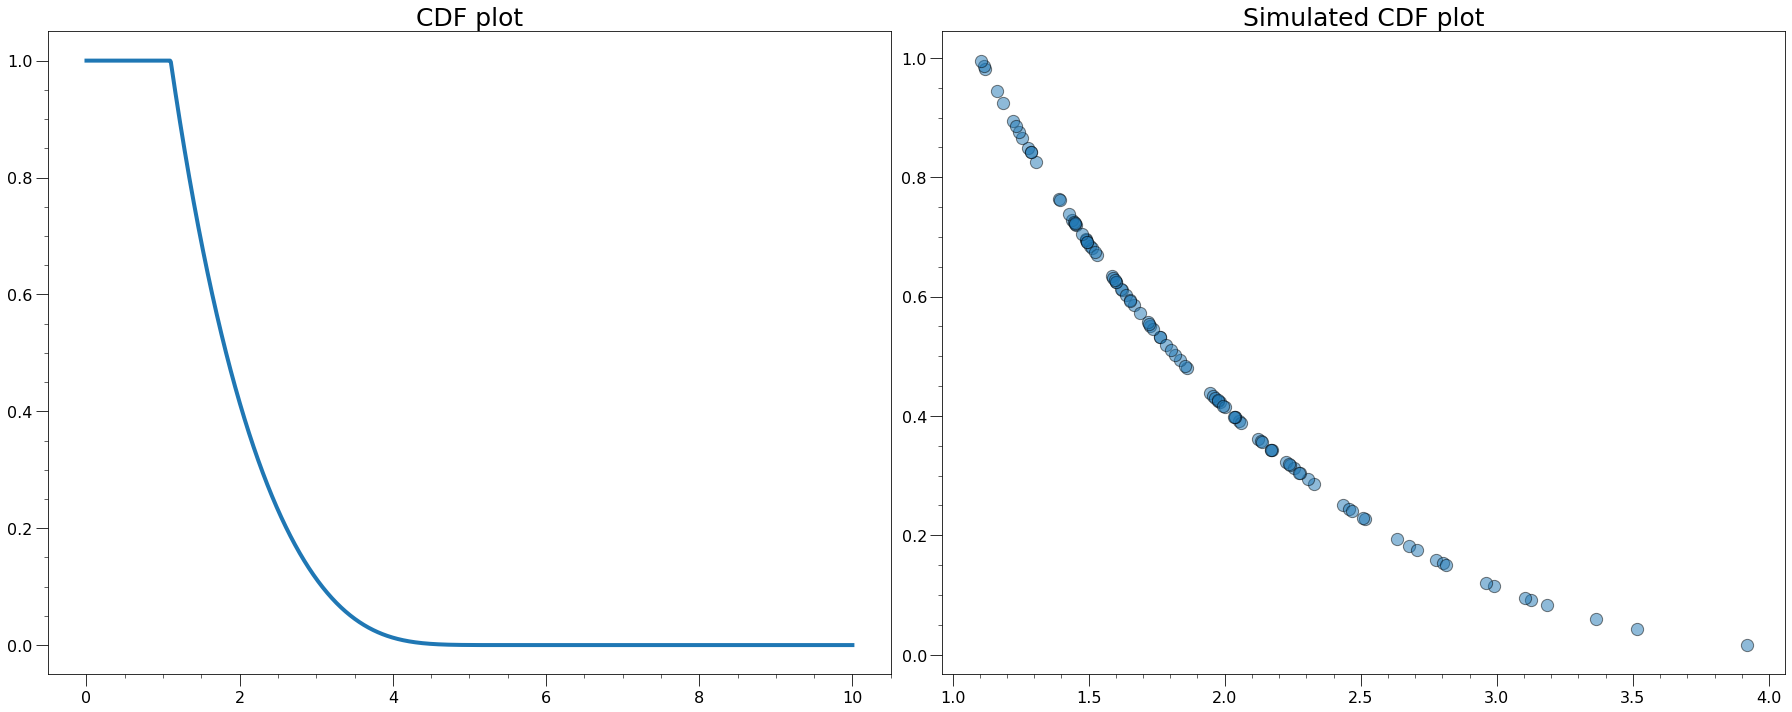

In [5]:
sim_t = draw_tau_numerical(ln_s_drawn,(1,0.9,0.1,1,1))
# plot of CDF
fig, ax = plt.subplots(1,2 , figsize=(25, 10))
ax[0].plot(np.linspace(0,10,1000), CDF(np.linspace(0,10,1000),(1,0.9,0.1,1,1)), linewidth=4)
ax[0].set_title('CDF plot', fontsize=25)
ax[0].xaxis.set_tick_params(labelsize=16, size=12)
ax[0].xaxis.set_tick_params(which='minor', size=4)
ax[0].yaxis.set_tick_params(labelsize=16, size=12)
ax[0].yaxis.set_tick_params(which='minor', size=4)
ax[1].set_title('Simulated CDF plot', fontsize=25)
ax[1].scatter(sim_t, CDF(sim_t,(1,0.9,0.1,1,1)), alpha=0.5, edgecolor='black', s=150)
ax[1].xaxis.set_tick_params(labelsize=16, size=12)
ax[1].xaxis.set_tick_params(which='minor', size=4)
ax[1].yaxis.set_tick_params(labelsize=16, size=12)
ax[1].yaxis.set_tick_params(which='minor', size=4)
ax[0].minorticks_on()
ax[1].minorticks_on()


fig.tight_layout()

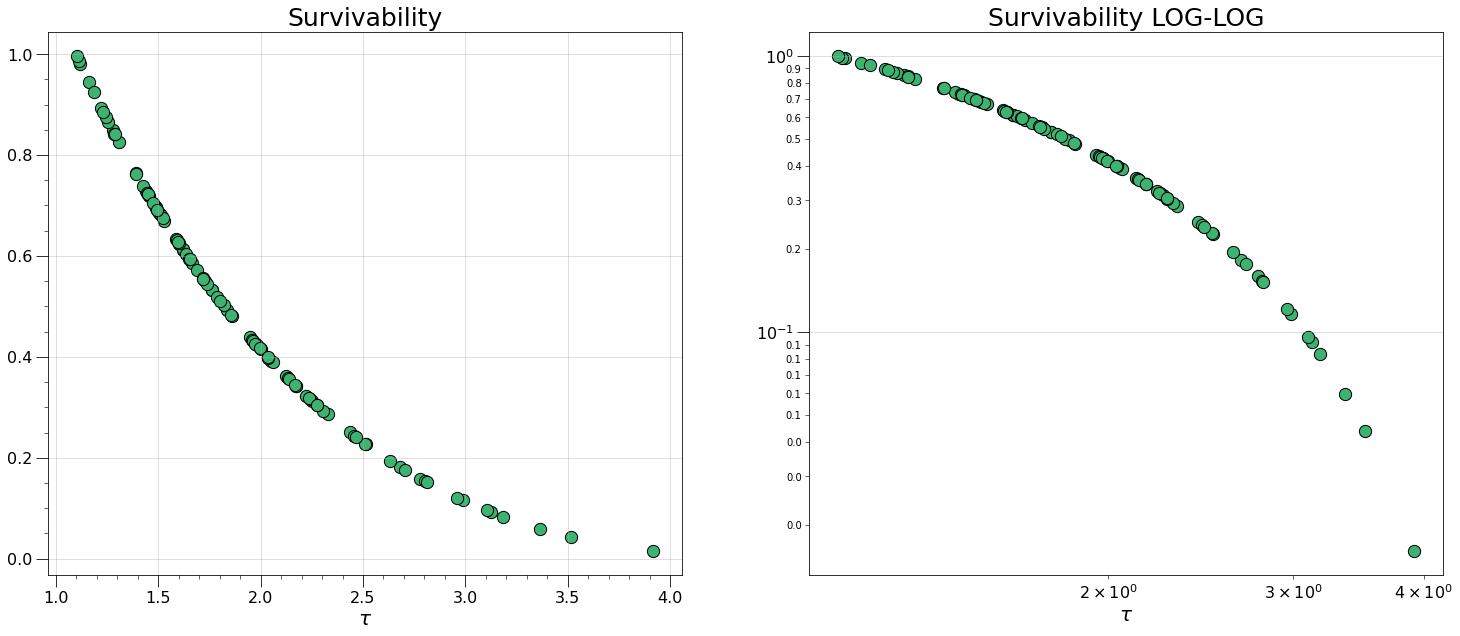

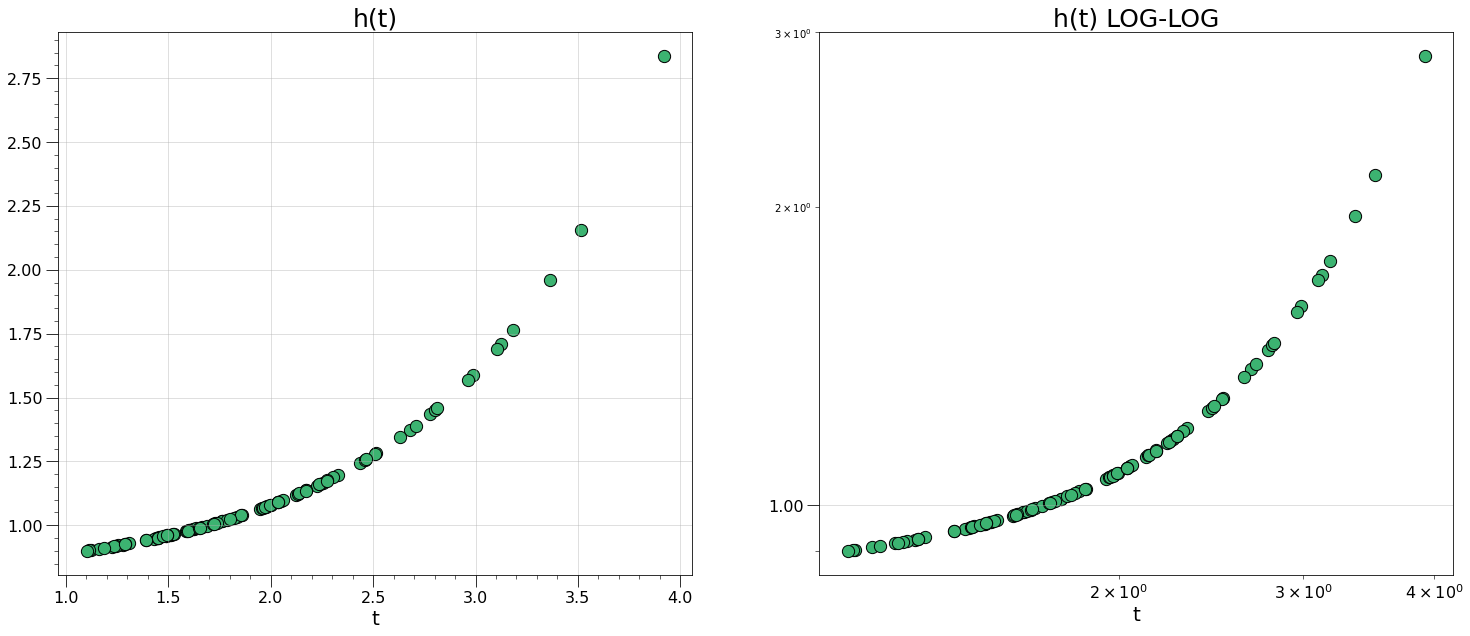

In [6]:
# PLOT s(t)
fig, ax = plt.subplots(1,2 , figsize=(25, 10))

ax[0].scatter(sim_t, CDF(sim_t, (1,0.9,0.1,1,1)), s=150, color='mediumseagreen', edgecolor='black')
ax[0].set_title('Survivability', fontsize=25)
ax[0].set_xlabel('$\\tau$', fontsize = 20)
ax[0].minorticks_on()
ax[0].grid(alpha=0.5)
ax[0].xaxis.set_tick_params(labelsize=16, size=12)
ax[0].xaxis.set_tick_params(which='minor', size=4)
ax[0].yaxis.set_tick_params(labelsize=16, size=12)
ax[0].yaxis.set_tick_params(which='minor', size=4)

ax[1].scatter(sim_t, CDF(sim_t, (1,0.9,0.1,1,1)), s=150, color='mediumseagreen', edgecolor='black')
ax[1].set_title('Survivability LOG-LOG', fontsize=25)
ax[1].set_xlabel('$\\tau$', fontsize = 20)
ax[1].minorticks_on()
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid(alpha=0.5)
ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].xaxis.set_tick_params(labelsize=16, size=12)
ax[1].xaxis.set_tick_params(which='minor', size=4, labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16, size=12)
ax[1].yaxis.set_tick_params(which='minor', size=4)


# PLOT h(t)
fig, ax = plt.subplots(1,2 , figsize=(25, 10))

ax[0].scatter(sim_t, h(sim_t, (1,0.9,0.1,1,1)), s=150, color='mediumseagreen', edgecolor='black')
ax[0].set_title('h(t)', fontsize=25)
ax[0].set_xlabel('t', fontsize = 20)
ax[0].minorticks_on()
ax[0].grid(alpha=0.5)
ax[0].xaxis.set_tick_params(labelsize=16, size=12)
ax[0].xaxis.set_tick_params(which='minor', size=4)
ax[0].yaxis.set_tick_params(labelsize=16, size=12)
ax[0].yaxis.set_tick_params(which='minor', size=4)

ax[1].scatter(sim_t, h(sim_t, (1,0.9,0.1,1,1)), s=150, color='mediumseagreen', edgecolor='black')
ax[1].set_title('h(t) LOG-LOG', fontsize=25)
ax[1].set_xlabel('t', fontsize = 20)
ax[1].minorticks_on()
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid(alpha=0.5)
ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].xaxis.set_tick_params(labelsize=16, size=12)
ax[1].xaxis.set_tick_params(which='minor', size=4, labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16, size=12)
ax[1].yaxis.set_tick_params(which='minor', size=4)


In [7]:
points_per_evolution=100     # number of time points between 2 divisions

t = 0
mb = 1
frac = 1/2#np.random.beta(a=2, b=2, size=size)
#omg_1 = #np.random.gamma(shape=2, scale=1, size=size)

all_times = np.zeros(points_per_evolution*size)
cell_sizes = np.zeros(points_per_evolution*size)
sim_t = []

for i in range(size): 
    parameters = (1,0.9,0.1,1,mb) # omega1, omega2, mu, nu, xb
    tau = draw_tau_numerical(ln_s_drawn[i], pars=parameters)
    sim_t.append(tau)

    # evolution
    times = np.linspace(0, tau, points_per_evolution)
    mt = m_function(times, parameters)
    # pt = p_function(times, parameters)
    
    # store times and sizes
    all_times[i*points_per_evolution : (i+1)*points_per_evolution] = np.linspace(t, t+tau, points_per_evolution)
    cell_sizes[i*points_per_evolution : (i+1)*points_per_evolution] = mt

    # update the initial time and the starting size
    mb = mt[-1]*frac
    t = t+tau

sim_t = np.array(sim_t)

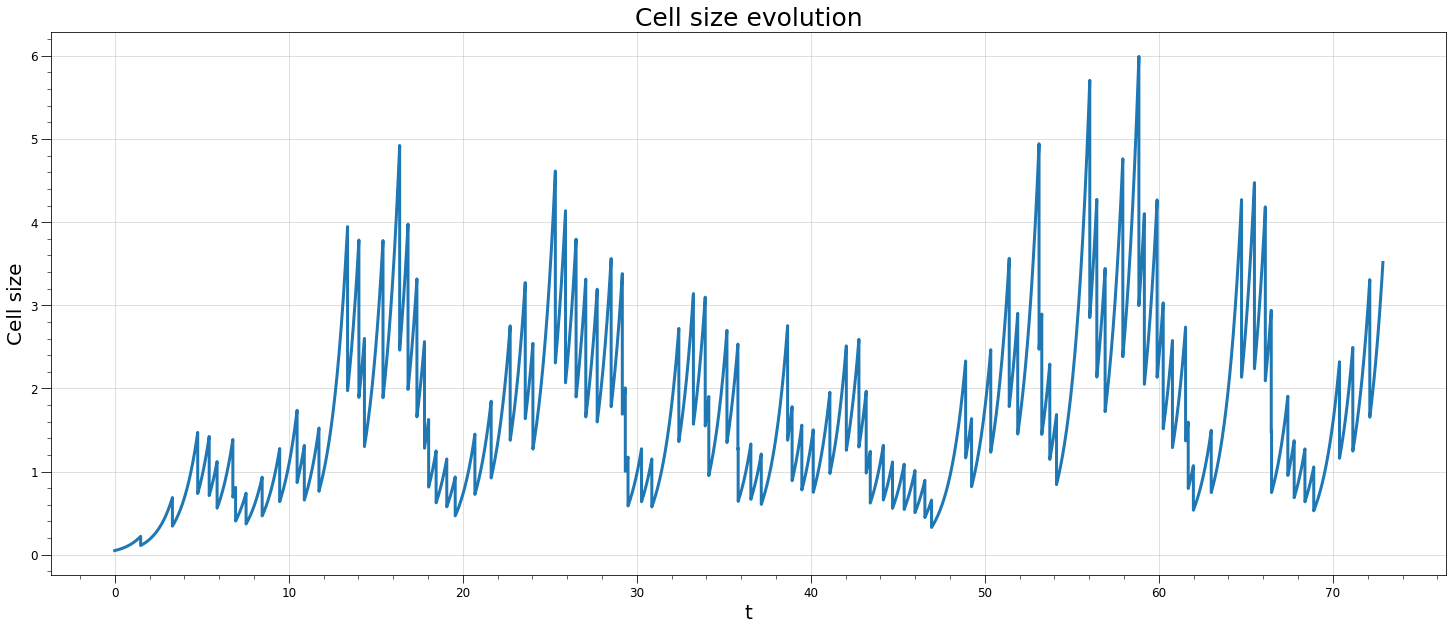

In [8]:
fig, ax = plt.subplots(1,1 , figsize=(25, 10))
ax.plot(all_times, cell_sizes, linewidth=3, color='C0')
ax.set_title('Cell size evolution', fontsize=25)
ax.set_xlabel('t', fontsize = 20)
ax.set_ylabel('Cell size', fontsize=20)
ax.xaxis.set_tick_params(labelsize=12, size=8)
ax.xaxis.set_tick_params(which='minor', size=4)
ax.yaxis.set_tick_params(labelsize=12, size=10)
ax.yaxis.set_tick_params(which='minor', size=4)
ax.minorticks_on()
ax.grid(alpha=0.5)

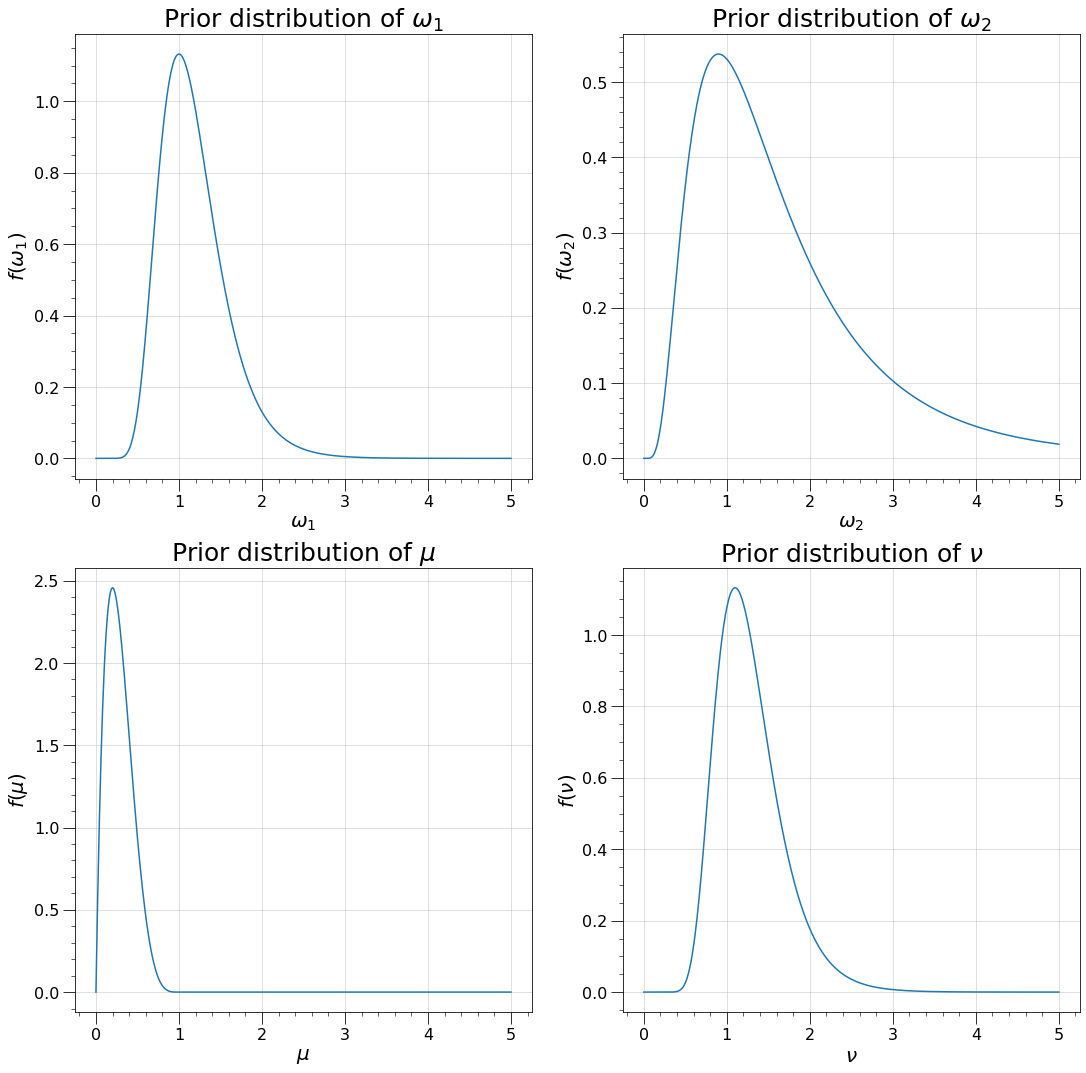

In [9]:
x = np.linspace(0, 5, 500)

_, ax = plt.subplots(2, 2, figsize=(18, 18))
ax[0, 0].plot(x, prior_omega1(x))
ax[0, 1].plot(x, prior_omega2(x)) 
ax[1, 0].plot(x, prior_mu(x)) 
ax[1, 1].plot(x, prior_nu(x))

param_str = [['$\omega_1$', '$\omega_2$'], ['$\mu$', '$\\nu$']]

for i in range(2):
    for j in range(2):
        ax[i, j].set_title('Prior distribution of ' + param_str[i][j], fontsize=25)
        ax[i, j].set_xlabel(param_str[i][j], fontsize=20)
        ax[i, j].set_ylabel('$f($'+param_str[i][j]+'$)$', fontsize=20)
        ax[i, j].minorticks_on()
        ax[i, j].grid(alpha=0.5)
        ax[i, j].xaxis.set_tick_params(labelsize=16, size=12)
        ax[i, j].xaxis.set_tick_params(which='minor', size=4, labelsize=16)
        ax[i, j].yaxis.set_tick_params(labelsize=16, size=12)
        ax[i, j].yaxis.set_tick_params(which='minor', size=4)

## Likelihood

To retrieve the likelihood we first retrieve the pdf as minus the derivative of the cdf.
We then have that 
$$
f(y|\theta) = \prod_i f(t_i|t_{i-1,..}, \theta)
$$

In [10]:
def PDF(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    unnormalized = h(t, pars)*CDF(t, pars)
    idx = np.argsort(t)
    normalization = np.trapz(x=t[idx], y=unnormalized[idx])

    return(unnormalized/normalization)

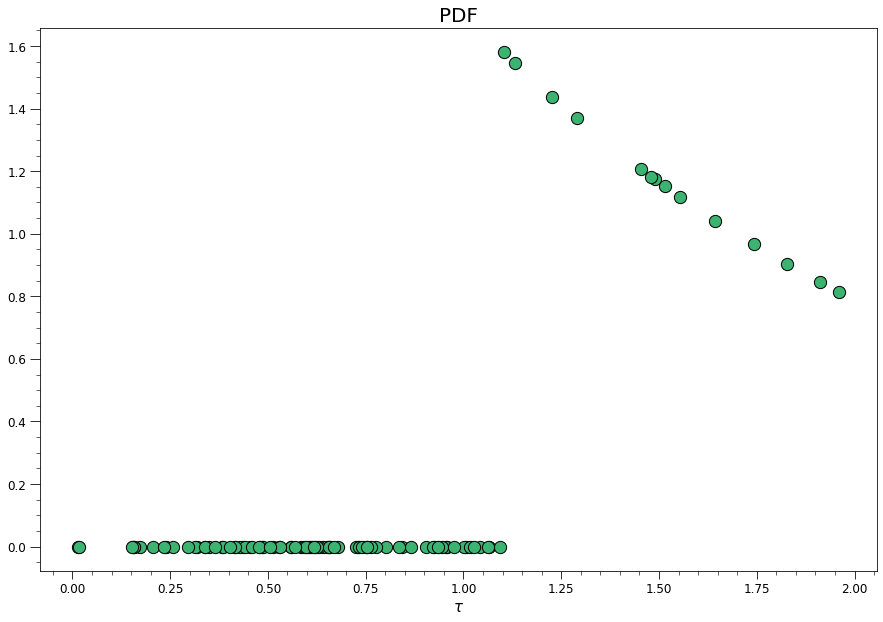

In [11]:
def log_likelihood(y, pars=(1,0.9,0.1,1,1)):
    return np.sum(np.log(PDF(y, pars)))

fig, ax = plt.subplots(1,1 , figsize=(15, 10))
ax.scatter(sim_t, PDF(sim_t, pars=(1,0.9,0.1,1,1)), s=150, color='mediumseagreen', edgecolor='black')
ax.set_title('PDF', fontsize=20)
ax.set_xlabel('$\\tau$', fontsize = 15)
ax.xaxis.set_tick_params(labelsize=12, size=8)
ax.xaxis.set_tick_params(which='minor', size=4)
ax.yaxis.set_tick_params(labelsize=12, size=10)
ax.yaxis.set_tick_params(which='minor', size=4)
ax.minorticks_on()

In [46]:
n_walkers = 20
ndim = 3

def j_log_unnorm_posterior_emcee(params, y_times):
    try:
        omega_1, omega_2, u, nu = np.array(params)
        
        #return(log_likelihood(y_times, pars=(1, omega_2, u, 1, 1)) + np.log(prior_omega2(omega_2)) + np.log(prior_mu(u)) + np.log(prior_omega1(omega_1))
    except:
        #omega_1, omega_2, u = np.array([0.00001, 0.000001, 0.00001])
        post_arr = [1, 0.9, 0.1, 1]
    
    ret = log_likelihood(y_times, pars=(omega_1, omega_2, u, nu, 1)) + np.log(prior_omega2(omega_2)) + np.log(prior_mu(u)) + np.log(prior_omega1(omega_1)) + np.log(prior_nu(nu))
    if ret*0 == 0:
        return(ret)
    else:
        return(-np.inf)


In [47]:
p0_omega_1 = np.random.uniform(low=0.6, high=1.3, size=n_walkers).reshape(-1, 1)
p0_omega_2 =np.random.uniform(low=0.5, high=1.2, size=n_walkers).reshape(-1, 1)
p0_u = np.random.uniform(low=0.05, high=0.15, size=n_walkers).reshape(-1, 1)
p0_nu = np.random.uniform(low=0.6, high=1.3, size=n_walkers).reshape(-1, 1)

p0 = np.hstack([p0_omega_1, p0_omega_2, p0_u, p0_nu])

sampler = emcee.EnsembleSampler(n_walkers, 4, j_log_unnorm_posterior_emcee, kwargs={'y_times':sim_t}, a=2)
'''
4  is the number of dimensions in the parameter space
a=2 is the proposal scale parameter. (default: 2.0)
'''

burn_in = 1700
n_steps = 5000

# burn-in 
pos, prob, state = sampler.run_mcmc(p0, burn_in)
sampler.reset()

# run mcmc
sampler.run_mcmc(pos, n_steps, rstate0=state)

# get chains
chain_start_sim = sampler.get_chain(flat=True)
'''
p0   is the initial state
5000 is the number of steps to run
'''


'\np0   is the initial state\n5000 is the number of steps to run\n'

In [48]:
# remove outliers (stucked chains) and flatten 
chain = chain[:, np.invert(np.all(chain == chain[0], axis=0))].reshape(-1, 4)


Median value of omega_1: 1.161
Max value of omega_1: 0.836
true value of omega_1: 1.0


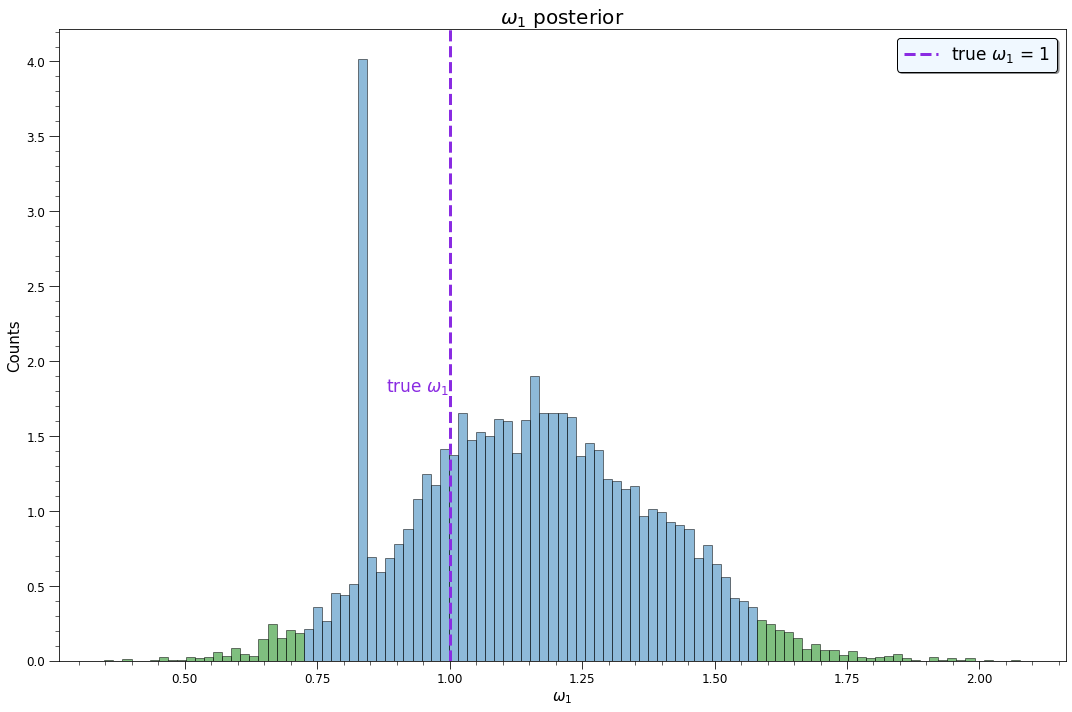

In [49]:
fig, ax = plt.subplots(1,1 , figsize=(15, 10))
res_omega_1 = ax.hist(chain[:,0], bins='fd', edgecolor='black', alpha=0.5, density=True)

counts_omega_1 = res_omega_1[0]
edges_omega_1 = res_omega_1[1]
patches_omega_1 = res_omega_1[2]
tmp = np.cumsum(np.diff(edges_omega_1)*counts_omega_1)

max_index = np.argmax(counts_omega_1)
max_omega_1 = (edges_omega_1[max_index] + edges_omega_1[max_index + 1])/2
median_omega_1 = (edges_omega_1[len(tmp[tmp<0.5])+1] + edges_omega_1[len(tmp[tmp<0.5])+2])/2
print('Median value of omega_1:', round(median_omega_1, 4))
for i in range(len(tmp[tmp<0.025])):
    patches_omega_1[i].set_facecolor('green')
for i in range(len(tmp[tmp<0.975]), len(tmp)):
    patches_omega_1[i].set_facecolor('green')

ax.minorticks_on()
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('$\\omega_1$', fontsize=15)
ax.set_title('$\\omega_1$ posterior', fontsize=20)

ax.axvline(1, color='blueviolet', linestyle='dashed',  linewidth=3, label='true $\omega_1$ = 1')

ax.text(1 - 0.12, 1.8, 'true $\omega_1$', color='blueviolet', fontsize=17)


print('Max value of omega_1:', round(max_omega_1, 4))
print('true value of omega_1:', 1.)

ax.legend(fontsize=17, facecolor='aliceblue', shadow = True, edgecolor='black')
ax.xaxis.set_tick_params(labelsize=12, size=8)
ax.xaxis.set_tick_params(which='minor', size=4)
ax.yaxis.set_tick_params(labelsize=12, size=10)
ax.yaxis.set_tick_params(which='minor', size=4)

fig.tight_layout()

Median value of omega_2: 0.7391
Max value of omega_2: 0.8931
true value of omega_2: 0.9


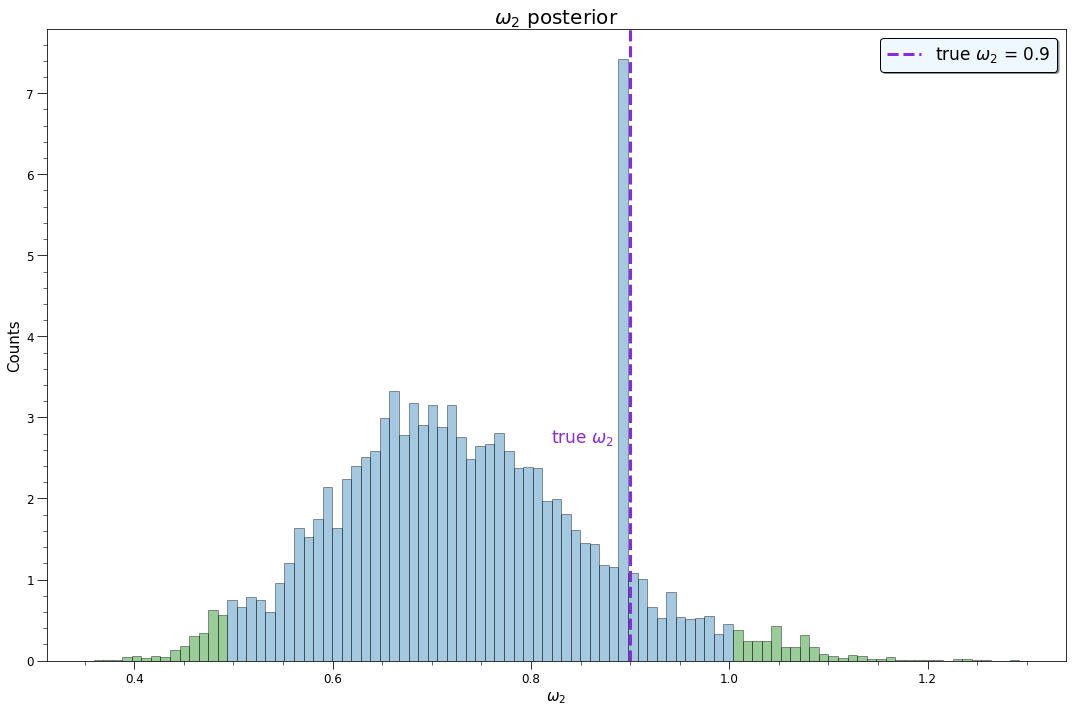

In [50]:
fig, ax = plt.subplots(1,1 , figsize=(15, 10))


res_omega_2 = ax.hist(chain[:,1], bins='fd', edgecolor='black', alpha=0.4, density=True)

counts_omega_2 = res_omega_2[0]
edges_omega_2 = res_omega_2[1]
patches_omega_2 = res_omega_2[2]
tmp = np.cumsum(np.diff(edges_omega_2)*counts_omega_2)

max_index = np.argmax(counts_omega_2)
max_omega_2 = (edges_omega_2[max_index] + edges_omega_2[max_index + 1])/2
median_omega_2 = (edges_omega_2[len(tmp[tmp<0.5])+1] + edges_omega_2[len(tmp[tmp<0.5])+2])/2
print('Median value of omega_2:', round(median_omega_2, 4))
for i in range(len(tmp[tmp<0.025])):
    patches_omega_2[i].set_facecolor('green')
for i in range(len(tmp[tmp<0.975]), len(tmp)):
    patches_omega_2[i].set_facecolor('green')

ax.minorticks_on()
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('$\\omega_2$', fontsize=15)
ax.set_title('$\\omega_2$ posterior', fontsize=20)
#ax.axvline(median_omega_2, color='crimson', linestyle='dashed',  linewidth=3 , label='median $\omega_2$ = ' + str(round(median_omega_2, 4)))
#ax.axvline(max_omega_2, color='darkgreen', linestyle='dashed',  linewidth=3, label='max $\omega_2$ = ' + str(round(max_omega_2, 4)))
ax.axvline(0.9, color='blueviolet', linestyle='dashed',  linewidth=3, label='true $\omega_2$ = 0.9')

#ax.text(median_omega_2+0.012, 3.2, 'median $\omega_2$', color='crimson', fontsize=17)
#ax.text(max_omega_2-0.075, 3.3, 'max $\omega_2$', color='darkgreen', fontsize=17)

ax.text(0.9 - 0.08, 2.7, 'true $\omega_2$', color='blueviolet', fontsize=17)
ax.xaxis.set_tick_params(labelsize=12, size=8)
ax.xaxis.set_tick_params(which='minor', size=4)
ax.yaxis.set_tick_params(labelsize=12, size=10)
ax.yaxis.set_tick_params(which='minor', size=4)

ax.legend(fontsize=17, facecolor='aliceblue', shadow = True, edgecolor='black')
print('Max value of omega_2:', round(max_omega_2, 4))
print('true value of omega_2:', 0.9)


fig.tight_layout()

Median value of mu: 0.0114
Max value of mu: 0.0993
true value of mu: 0.1


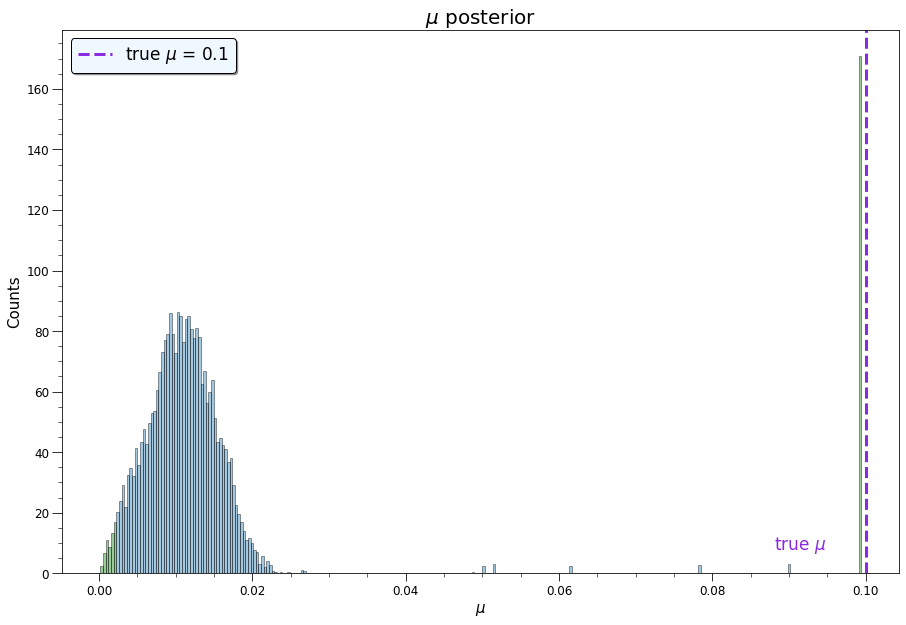

In [51]:
fig, ax = plt.subplots(1,1 , figsize=(15, 10))

res_mu = ax.hist(chain[:,2], bins='fd', edgecolor='black', alpha=0.4, density=True)

counts_mu = res_mu[0]
edges_mu = res_mu[1]
patches_mu = res_mu[2]
tmp = np.cumsum(np.diff(edges_mu)*counts_mu)

max_index = np.argmax(counts_mu)
max_mu = (edges_mu[max_index] + edges_mu[max_index + 1])/2
median_mu = (edges_mu[len(tmp[tmp<0.5])+1] + edges_mu[len(tmp[tmp<0.5])+2])/2
print('Median value of mu:', round(median_mu, 4))
for i in range(len(tmp[tmp<0.025])):
    patches_mu[i].set_facecolor('green')
for i in range(len(tmp[tmp<0.975]), len(tmp)):
    patches_mu[i].set_facecolor('green')

ax.minorticks_on()
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('$\\mu$', fontsize=15)
ax.set_title('$\\mu$ posterior', fontsize=20)
ax.xaxis.set_tick_params(labelsize=12, size=8)
ax.xaxis.set_tick_params(which='minor', size=4)
ax.yaxis.set_tick_params(labelsize=12, size=10)
ax.yaxis.set_tick_params(which='minor', size=4)

ax.axvline(0.1, color='blueviolet', linestyle='dashed',  linewidth=3, label='true $\mu$ = 0.1')
ax.legend(fontsize=17, facecolor='aliceblue', shadow = True, edgecolor='black')

ax.text(0.1-0.012, 8, 'true $\mu$', color='blueviolet', fontsize=17)
print('Max value of mu:', round(max_mu, 4))
print('true value of mu:', 0.1)


#fig.tight_layout()

Median value of nu: 1.1105
Max value of nu: 1.0886
true value of nu: 1


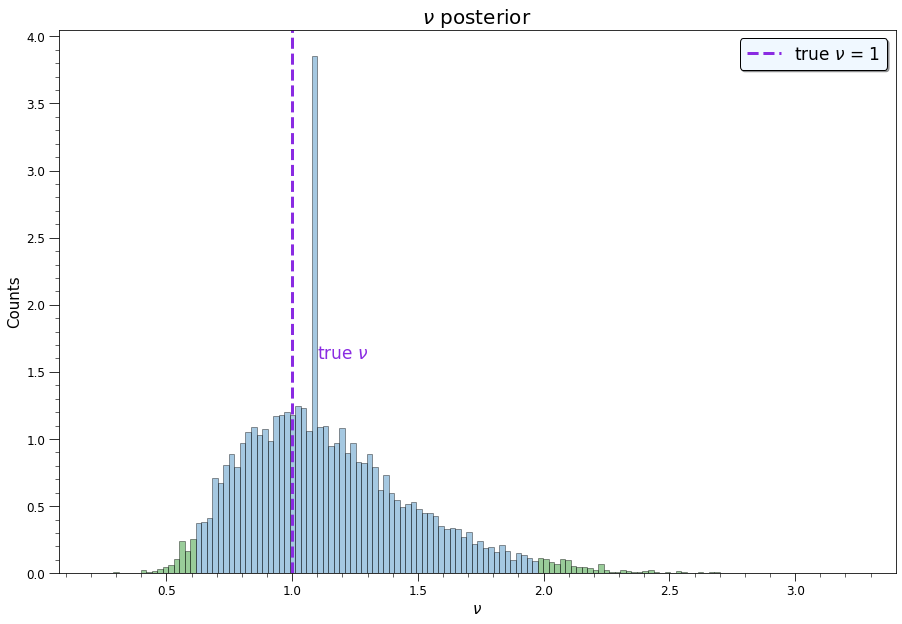

In [52]:
fig, ax = plt.subplots(1,1 , figsize=(15, 10))

res_nu = ax.hist(chain[:,3], bins='fd', edgecolor='black', alpha=0.4, density=True)

counts_nu = res_nu[0]
edges_nu = res_nu[1]
patches_nu = res_nu[2]
tmp = np.cumsum(np.diff(edges_nu)*counts_nu)

max_index = np.argmax(counts_nu)
max_nu = (edges_nu[max_index] + edges_nu[max_index + 1])/2
median_nu = (edges_nu[len(tmp[tmp<0.5])+1] + edges_nu[len(tmp[tmp<0.5])+2])/2
print('Median value of nu:', round(median_nu, 4))
for i in range(len(tmp[tmp<0.025])):
    patches_nu[i].set_facecolor('green')
for i in range(len(tmp[tmp<0.975]), len(tmp)):
    patches_nu[i].set_facecolor('green')

ax.minorticks_on()
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('$\\nu$', fontsize=15)
ax.set_title('$\\nu$ posterior', fontsize=20)
ax.xaxis.set_tick_params(labelsize=12, size=8)
ax.xaxis.set_tick_params(which='minor', size=4)
ax.yaxis.set_tick_params(labelsize=12, size=10)
ax.yaxis.set_tick_params(which='minor', size=4)

ax.axvline(1, color='blueviolet', linestyle='dashed',  linewidth=3, label='true $\\nu$ = 1')
ax.legend(fontsize=17, facecolor='aliceblue', shadow = True, edgecolor='black')

ax.text(1.1, 1.6, 'true $\\nu$', color='blueviolet', fontsize=17)
print('Max value of nu:', round(max_nu, 4))
print('true value of nu:', 1)


In [53]:
chain_df = pd.DataFrame(chain, columns=['omega1', 'omega2', 'mu', 'nu'])

chain_df.head()


,omega1,omega2,mu,nu
0,1.256368,0.895199,0.073190,0.919389
1,0.744281,1.019232,0.048818,0.630393
2,0.835438,0.891817,0.099431,1.094981
3,1.145551,0.976359,0.015785,0.630727
4,1.096736,1.138492,0.026607,0.628478


/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: Th

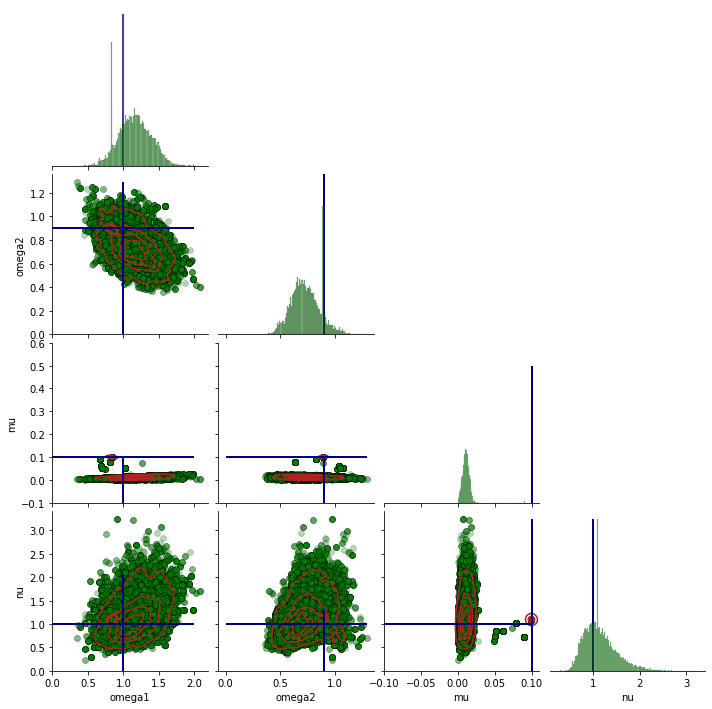

In [54]:
g = sns.pairplot(chain_df, diag_kind="hist", corner=True, plot_kws={'color':'green', 'edgecolor':'black', 'alpha':0.3}, diag_kws={'color':'green', 'alpha':0.5})
g.map_lower(sns.kdeplot, levels=5, color="firebrick", linewidth=2)
axes = g.axes.ravel()
axes_2 = []
for ax in axes:
    if ax != None:
        axes_2.append(ax)
axes_2
axes_2[0].vlines(x=1, ymin=0, ymax=1, color='navy')
axes_2[1].vlines(x=1, ymin=0, ymax=np.max(chain[:,1]), linewidth=2, color='navy')
axes_2[2].set_ylim(bottom=0)
axes_2[4].set_ylim(bottom=0)
axes_2[6].set_ylim(bottom=0)
axes_2[0].set_ylim(bottom=0)
axes_2[1].hlines(y=0.9, xmin=0, xmax=2, linewidth=2, color='navy')
axes_2[2].vlines(x=0.9, ymin=0, ymax=6, linewidth=2, color='navy')
axes_2[3].vlines(x=1, ymin=-0.1, ymax=np.max(chain[:,2]), linewidth=2, color='navy')
axes_2[3].hlines(y=0.1, xmin=0, xmax=2, linewidth=2, color='navy')
axes_2[4].vlines(x=0.9, ymin=-0.1, ymax=np.max(chain[:,2]), linewidth=2, color='navy')
axes_2[4].set_ylim(bottom=-0.1, top=0.6)
axes_2[4].hlines(y=0.1, xmin=0, xmax=np.max(chain[:,1]), linewidth=2, color='navy')
axes_2[5].vlines(x=0.1, ymin=-0.1, ymax=0.5, linewidth=2, color='navy')
axes_2[6].vlines(x=1, ymin=0, ymax=np.max(chain[:,0]), linewidth=2, color='navy')
axes_2[6].hlines(y=1, xmin=0, xmax=2, linewidth=2, color='navy')
axes_2[6].set_xlim(left=0)
axes_2[7].vlines(x=0.9, ymin=0, ymax=np.max(chain[:,1]), linewidth=2, color='navy')
axes_2[7].hlines(y=1, xmin=0, xmax=np.max(chain[:,1]), linewidth=2, color='navy')
axes_2[8].vlines(x=0.1, ymin=0, ymax=np.max(chain[:,3]), linewidth=2, color='navy')
axes_2[8].hlines(y=1, xmin=-0.1, xmax=np.max(chain[:,2]), linewidth=2, color='navy')
axes_2[8].set_xlim(left=-0.1)
axes_2[9].vlines(x=1, ymin=0, ymax=np.max(chain[:,3]), linewidth=2, color='navy')


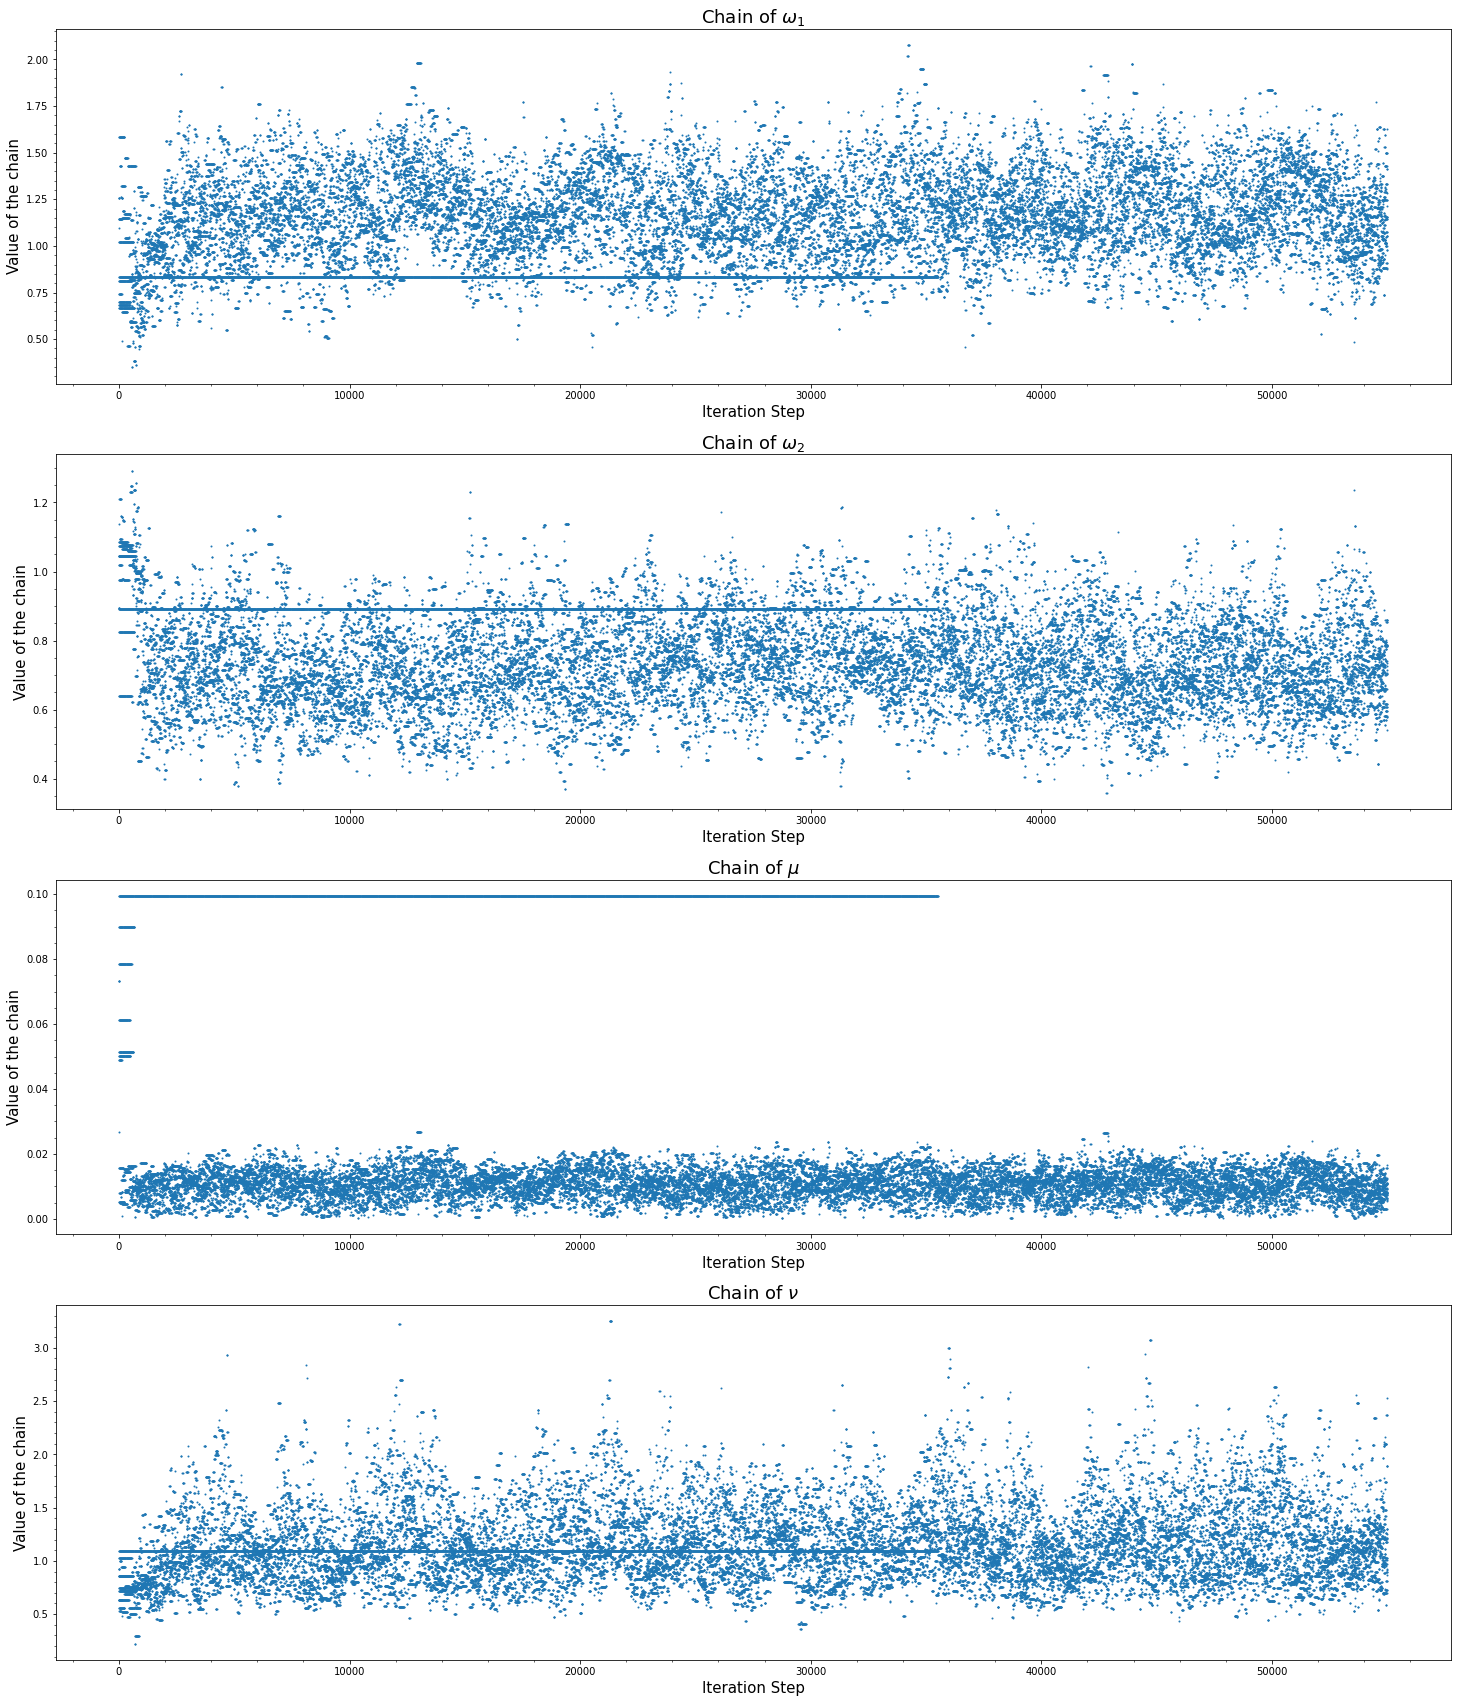

In [55]:
fig , ax = plt.subplots(4,1, figsize=(25, 30))

title_list = ['$\omega_1$', '$\omega_2$', '$\mu$', '$\\nu$']
for i, i_title in zip(range(4), title_list):
    ax[i].scatter(range(len(chain[:, i])) , chain[:,i], s=1)
    ax[i].set_ylabel('Value of the chain', fontsize=15)
    ax[i].set_xlabel('Iteration Step', fontsize=15)
    ax[i].set_title('Chain of '+i_title, fontsize=18)
    ax[i].minorticks_on()


# References
- Held J, Lorimer T, Pomati F, Stoop R, Albert C. Second-order phase transition in phytoplankton trait dynamics. _Chaos_. 2020;30(5):053109. doi:10.1063/1.5141755 
- emcee documentation: https://emcee.readthedocs.io/en/stable/

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=83986fd3-ecbf-4c81-9b1b-e1048abf0732' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>